# Naive Bayes Classifier

In [15]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score
from sklearn.metrics import make_scorer, get_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay


In [16]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [17]:
train_data.drop(columns=['top_20_entropy'], inplace=True)
test_data.drop(columns=['top_20_entropy'], inplace=True)

## Preprocessing Pipeline

In [18]:
cat_features = ['is_tarmac', 'length_cat', 'climb_cat']
num_features = [col for col in train_data.columns if col not in cat_features]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

## Logistic Regression Model

In [19]:
#pipeline
from sklearn.model_selection import GridSearchCV


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', GaussianNB())])
param_grid = {
    'classifier__var_smoothing': np.logspace(0,-9, num=100)
}

scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1')
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['points',
                                                                          'cyclist_age',
                                                                          'cyclist_level',
                                                                          'avg_relative_position',
                                                                          'avg_rel_position_profile',
                                                                          'avg_cyclist_level']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['is_tarmac',
                                                                          'length_cat',
                                                                          'climb_cat'])])),
                                       ('classifier', GaussianNB())]),
             n_...
                      'f1': make_scorer(f1_score, response_method='predict', average=binary),
                      'precision': make_scorer(precision_score, response_method='predict', average=binary),
                      'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                      'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                      'specificity': make_scorer(specificity_score, response_method='predict')})

In [20]:
# best model
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['points', 'cyclist_age',
                                                   'cyclist_level',
                                                   'avg_relative_position',
                                                   'avg_rel_position_profile',
                                                   'avg_cyclist_level']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['is_tarmac', 'length_cat',
                                                   'climb_cat'])])),
                ('classifier',
                 GaussianNB(var_smoothing=np.float64(0.04328761281083057)))])

Accuracy: 0.7457377745419245
Recall: 0.3116308470290771
Precision: 0.2243118222491848
Sensitivity: 0.3116308470290771
Specificity: 0.8187504429796584
F1 Score: 0.2608580625248027
ROC AUC Score: 0.5651906450043678


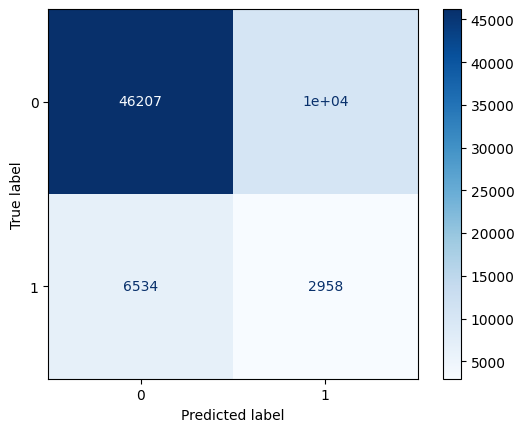

In [21]:
import matplotlib.pyplot as plt

# Predict on the test data
test_predictions = grid_search.predict(test_data)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity = sensitivity_score(test_labels, test_predictions)
specificity = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
